In [1]:
from NeuralNetworks.activationfunctions import *
from NeuralNetworks.numerical_integration import *
from NeuralNetworks.Train import *
import numpy as np
import matplotlib.pyplot as plt


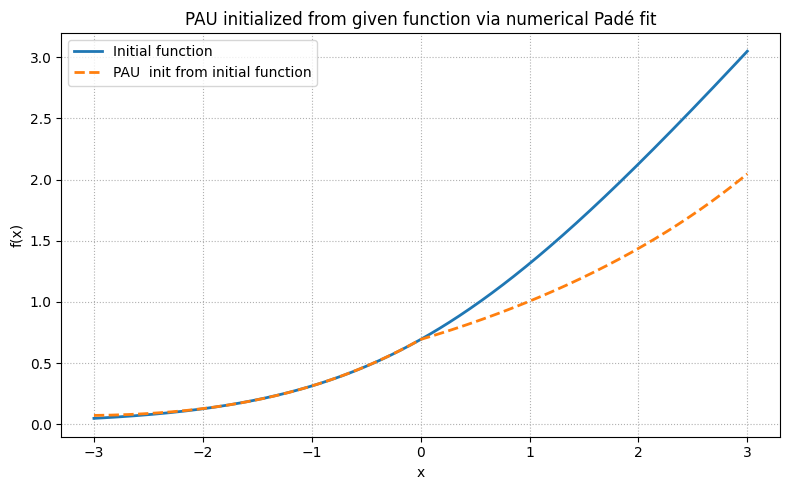

In [2]:
def test_PAU_initialization(n=5,m=4, init_func=torch.nn.Softplus()):
    act = PAU(n_numerator=n, n_denominator=m, init_func=init_func)

    x = torch.linspace(-3, 3, 600, dtype=torch.float32)
    with torch.no_grad():
        y_true = init_func(x)
        y_pau  = act(x)

    x_np = x.cpu().numpy()
    plt.figure(figsize=(8, 5))
    plt.plot(x_np, y_true.cpu().numpy(), label="Initial function", linewidth=2)
    plt.plot(x_np, y_pau.cpu().numpy(), "--", label="PAU  init from initial function", linewidth=2)
    plt.title("PAU initialized from given function via numerical Padé fit")
    plt.xlabel("x"); plt.ylabel("f(x)")
    plt.legend(); plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

test_PAU_initialization(n=2,m=2, init_func = torch.nn.Softplus())

## The average vector field (AVF) integrator for the 1D heat equation

We consider the one–dimensional heat equation
$$
u_t = u_{xx}, \qquad x \in [0,L], \quad t>0,
$$
subject to Dirichlet boundary conditions \(u(0,t)=u(L,t)=0\).



### Reformulation

The PDE can be written on the form
$$
\dot{u} = N \nabla H(u),
$$
where $N$ is a negative–definite operator and $H(u)$ is a Lyapunov function.
Two equivalent formulations exist:

1. $N_1 = -I,\quad H_1(u) = \tfrac12\int_0^L |u_x|^2\,dx,$
2. $N_2 = \partial_{xx},\quad H_2(u) = \tfrac12\int_0^L |u|^2\,dx.$

Both lead to the same evolution equation $u_t = u_{xx}$ and both energies $H_1$ and $H_2$
are decreasing.




### Semi–discrete system

After spatial discretisation on a uniform grid $x_j=j\Delta x \quad j=0,\ldots,N$ applying a central difference scheme on the laplacian, we obtain
the tridiagonal matrix

$$
A = \frac{1}{(\Delta x)^2}\operatorname{tridiag}(1,-2,1),
$$
yielding the semi–discrete system 
$$
\dot{\mathbf{u}} = A\,\mathbf{u}.
$$


The discrete Lyapunov functions are
$$
H_1(\mathbf{u}) = \tfrac12\,\mathbf{u}^\top(-A)\mathbf{u},
\qquad
H_2(\mathbf{u}) = \tfrac12\,\mathbf{u}^\top\mathbf{u}.
$$




### Average Vector Field (AVF) time discretisation

For the system $\dot{\mathbf{u}} = A\mathbf{u}$,  
the AVF scheme is
$$
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}
= \int_0^1 A\!\left((1-\xi)\mathbf{u}^n + \xi \mathbf{u}^{n+1}\right)d\xi.
$$
Since $A$ is linear, the integral simplifies to
$$
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}
= A\frac{\mathbf{u}^{n+1}+\mathbf{u}^n}{2},
$$
which yields the update rule 
$$
\boxed{(I - \tfrac{\Delta t}{2}A)\mathbf{u}^{n+1}
       = (I + \tfrac{\Delta t}{2}A)\mathbf{u}^n.}
$$





### Numerical setup

- Domain: $x\in[0,L]$ with $L=1$
- Grid: $N$ subintervals, $\Delta x = L/N$
- Boundary conditions: $u(0)=u(L)=0$
- Initial condition: $u(x,0)=x(1-x)$

The AVF update
$$
(I - \tfrac{\Delta t}{2}A)\mathbf{u}^{n+1}
  = (I + \tfrac{\Delta t}{2}A)\mathbf{u}^{n}
$$
is solved each step using an LU factorisation of the constant matrix $(I - \tfrac{\Delta t}{2}A)$.


In [3]:
from scipy.sparse import diags
from scipy.linalg import lu_factor, lu_solve

def create_sparse_tridiagonal(n, a = 1, b = -2, c = 1):
    diagonals = [np.full(n-1, a), np.full(n, b), np.full(n-1, c)]
    return diags(diagonals, offsets=[-1, 0, 1]).toarray()

In [4]:
def AVF(L= 1, N = 50, dt = 0.0025, T = 0.25, A = None):
    x = np.linspace(0, L, N + 1)
    dx = L / N
    N_t = int(T / dt)

    #Initial condition
    u = x*(1-x)

    #Dirichlet BCs, u(0)=u(L)=0
    u[0] = 0.0
    u[-1] = 0.0

    #Discrete Laplacian (negative definite N operator)
    if A is None:
        tridiag = create_sparse_tridiagonal(n=N-1)
        A = 1/dx**2*tridiag

    #(I - dt/2 * A) u^{n+1} = (I + dt/2 * A) u^n
    I = np.eye(N-1)
    LHS = I - 0.5 * dt * A
    RHS = I + 0.5 * dt * A

    #Precompute LU factorization for efficiency
    lu, piv = lu_factor(LHS)

    u_all = [u.copy()]
    t_all = [0.0]

    for n in range(N_t):
        u_old = u[1:-1]
        rhs = RHS @ u_old
        u_new = lu_solve((lu, piv), rhs)
        u[1:-1] = u_new

        #Save every 10th time step
        #if (n + 1) % 10 == 0:
        u_all.append(u.copy())
        t_all.append((n + 1) * dt)

    return x, np.array(t_all), np.array(u_all)

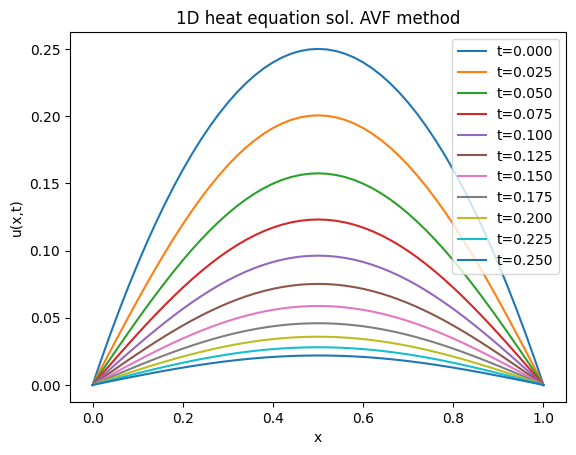

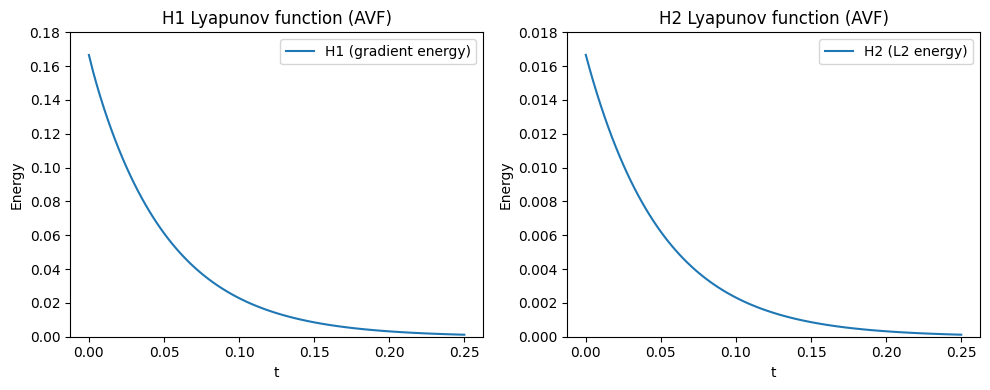

In [5]:
L=1.0
N=50
T=0.25
dt=0.0025

x, t, U = AVF(L=L, N=N, dt=dt, T=T)

plt.figure()
#Only plot every 20th time step 
for i in range(0, len(t), 10):     
    plt.plot(x, U[i], label=f"t={t[i]:.3f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D heat equation sol. AVF method")
plt.legend()
plt.show()


dx = x[1] - x[0]
A = (1/dx**2) * create_sparse_tridiagonal(n = N-1)
H1 = [0.5 * u[1:-1].T @ (-A) @ u[1:-1] * dx for u in U]
H2 = [0.5 * np.sum(u[0:-1]**2) * dx   for u in U]


fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

axes[0].plot(t, H1, label='H1 (gradient energy)')
axes[0].set_xlabel("t")
axes[0].set_ylabel("Energy")
axes[0].legend()
axes[0].set_ylim(0, 0.18)  
axes[0].set_title("H1 Lyapunov function (AVF)")

axes[1].plot(t, H2, label='H2 (L2 energy)')
axes[1].set_xlabel("t")
axes[1].set_ylabel("Energy")
axes[1].legend()
axes[1].set_ylim(0, 0.018)  
axes[1].set_title("H2 Lyapunov function (AVF)")

plt.tight_layout()
plt.show()



In [6]:
U

array([[0.        , 0.0196    , 0.0384    , ..., 0.0384    , 0.0196    ,
        0.        ],
       [0.        , 0.01746061, 0.03503662, ..., 0.03503662, 0.01746061,
        0.        ],
       [0.        , 0.01687834, 0.03345497, ..., 0.03345497, 0.01687834,
        0.        ],
       ...,
       [0.        , 0.00144437, 0.00288305, ..., 0.00288305, 0.00144437,
        0.        ],
       [0.        , 0.00140918, 0.0028128 , ..., 0.0028128 , 0.00140918,
        0.        ],
       [0.        , 0.00137485, 0.00274427, ..., 0.00274427, 0.00137485,
        0.        ]], shape=(101, 51))

In [7]:
import autograd.numpy as np
import autograd
from scipy.integrate import solve_ivp


class HeatEquation:

    """Pseudo-Hamiltonian formulation of the heat equation.
    
    General Pseudo-Hamiltonian formulation: du/dt = S*grad[H(u)] - R*grad[V(u)] + F(u, t, xspatial)

    Heat Equation Pseudo-Hamiltonian formulation: S = 0, R = -I, F = 0 -> du/dt = -grad[V(u)]

    A is a symmetric matrix, R is the symmetric dissipation matrix, H and V are discretized integrals of the system.

    u is the system state, t is time and xspatial is the space x. 

    Parameters
    ----------
    L:
    N:
    dr:
    T:
    A:
    
    """
    def __init__(self,L= 1, N = 10, dt = 0.0025, T = 0.25, A = None,B = None, init_sampler = None, nstates = None, seed = 42):
        self.N = N  #M = N+1
        if nstates is None:
            nstates = N+1
        self.x = np.linspace(0, L, N + 1)
        self.dx = L / N
        self.N_t = int(T / dt)
        self.nstates = nstates
 
        if A is None:
            #Central diff approx of Laplacian u_xx
            tridiag = create_sparse_tridiagonal(n=N+1) #N+1 hos sintef med -2500 øverst til høyre og nederst til venstre.
            A = 1/self.dx**2*tridiag

        if B is None:
            #Forward diff approx of u_x
            twodiag = create_sparse_tridiagonal(n=N+1, a = 0, b = -1, c = 1) #N+1 hos sintef med -50 nederst til venstre.
            B = 1/self.dx*twodiag

     
        #Boundary conditions
        A[0,-1] = 1/self.dx**2
        A[-1,0] = 1/self.dx**2


        B[-1,0] = 1/self.dx

        self.A = A
        self.B = B

        self.lhs_matrix = dx * np.eye(N+1)

        if init_sampler is not None:
            self._initial_condition_sampler = init_sampler

        self.rng = np.random.default_rng(seed)

        
    def V(self,u):
        #dV(u) = u_xx -> V(u) = -0.5 int(u_x^2) dx ??
        return np.sum(-0.5 * (np.matmul(self.B, u.T) ** 2).T, axis=1)

    def dV(self,u):
        #N = -1, H(u) = 0.5 int(u_x^2) dx
        #Central diff: u_xx = Au -> dH(u) = - Au
        #u_xx = dudt = NdH(u) =- dV = - Au
        #-> dV = Au 
        #return  u @ self.A
        return  u @ self.A

    def ddV(self,u):
        #dV = Au -> ddV = A
        return self.A
    
    def _dV(self, u):
        V = lambda u: self.V(u).sum()
        return autograd.grad(V)(u)

    def _ddV(self, u):
        V = lambda u: self.V(u).sum()
        return autograd.hessian(V)(u)

    def _initial_condition_sampler(self, rng=None):
        if rng is None:
            assert self.rng is not None
            rng = self.rng
        return rng.uniform(low=-1.0, high=1.0, size=self.nstates)


    def u_dot(self, u, t):
        """

        Computes du/dt = -grad[V(u)], i.e the time derivative of the state u
        The right hand side of the pseudo-Hamiltonian formulation.

        """
        #return self._dV(u)
        g = self._dV(u)            # shape (1, nstates)
        g[:, 0]  = 0.0
        g[:, -1] = 0.0
        return g



    def u_dot_jacobian(self, u, t):
        """
        Computes the Jacobian of the right hand side of the pseudo-
        Hamiltonian equation.

        """
        return self._ddV(u)
    


    def sample_trajectory(self, t, u0=None, noise_std=0, add_noise=False, integrator=None, BDF=False):
        if u0 is None:
            #u0 = self._initial_condition_sampler(self.rng)
            u0 = self.x * (1 - self.x)
            u0[0] = 0.0
            u0[-1] = 0.0

        #if self.lhs_matrix is not None:
           # lhs_matrix_inv = np.linalg.inv(self.lhs_matrix)
          #  u_dot = lambda t, x: np.matmul(lhs_matrix_inv, self.u_dot(x.reshape(1, x.shape[-1]), np.array(t).reshape((1, 1))).T,).T
       # else:
        #u_dot = lambda t, u: self.u_dot(u.reshape(1, u.shape[-1]), np.array(t).reshape((1, 1)))
        J = np.zeros_like(self.A)
        J[1:-1, 1:-1] = self.A[1:-1, 1:-1]
        if BDF:
            out_ivp = solve_ivp(
                fun=lambda ts, y: self.u_dot(y.reshape(1,-1), np.array([[ts]])).ravel(),
                t_span=(t[0], t[-1]),
                y0=u0,
                t_eval=t,
                method="BDF",
                jac=lambda ts, y: J,
                rtol=1e-6, atol=1e-8
            )

        
            #out_ivp = solve_ivp(fun=u_dot, t_span=(t[0], t[-1]), y0=u0, t_eval=t, rtol=1e-10)
            u, t = out_ivp["y"].T, out_ivp["t"].T
        else:
            dt = float(t[1] - t[0])                 # assumes uniform time grid
            A_int = self.A[1:-1, 1:-1]              # interior block (Dirichlet)
            m = A_int.shape[0]
            I = np.eye(m)

            LHS = I - 0.5 * dt * A_int
            RHS = I + 0.5 * dt * A_int
            lu, piv = lu_factor(LHS)

            U = np.zeros((len(t), self.N + 1))
            U[0] = u0

            for n in range(len(t) - 1):
                ui = U[n, 1:-1]
                U[n+1, 1:-1] = lu_solve((lu, piv), RHS @ ui)
                U[n+1, 0] = 0.0
                U[n+1, -1] = 0.0

            u = U
            t = np.asarray(t)

        dudt = self.u_dot(u, t)

        if add_noise:
            u += self.rng.normal(size=u.shape) * noise_std
            dudt += self.rng.normal(size=dudt.shape) * noise_std

        return u, dudt, t, u0

In [8]:
from NeuralNetworks.numerical_integration import *
from tqdm import tqdm

In [9]:
def generate_data(system, ntrajectories, t_sample, integrator, xspatial = None, true_derivatives=False, u0s=None, data_type=torch.float32, BDF = False):
    nstates = system.nstates
    traj_length = t_sample.shape[0]

    u = np.zeros((ntrajectories,traj_length,nstates))
    dudt = np.zeros_like(u)
    t = np.zeros((ntrajectories,traj_length))
    u0_ = np.zeros((ntrajectories, nstates))

    for i in tqdm(range(ntrajectories)):
        if u0s is not None:
            u0 = np.array(u0s[i])
            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,u0=u0,integrator=integrator,BDF=BDF)
        else:
            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,integrator=integrator, BDF=BDF)

    dt = torch.tensor([t[0, 1] - t[0, 0]], dtype=data_type)


    u_start = torch.tensor(u[:, :-1], dtype=data_type).reshape(-1, 1, nstates)
    u_end = torch.tensor(u[:, 1:], dtype=data_type).reshape(-1, 1, nstates)
    t_start = torch.tensor(t[:, :-1], dtype=data_type).reshape(-1, 1, 1)
    dt = dt * torch.ones_like(t_start, dtype=data_type)

    dudt_tensor = torch.tensor(dudt[:, :-1], dtype=data_type).reshape(-1, 1, nstates) if true_derivatives else (u_end - u_start) / dt[0, 0]

    if xspatial is None:
        xspatial = system.x
   
    xspatial = torch.tensor(
        np.repeat(xspatial.reshape(1, 1, -1), dudt_tensor.shape[0], axis=0), dtype=data_type
    ).reshape(dudt_tensor.shape[0], 1, -1)

    

    return (u_start, u_end, t_start, dt, xspatial), dudt_tensor, u, u0_


In [10]:
L=1.0
N=10
T=0.25
dt=0.0025

sys = HeatEquation(N = N, L=L, dt=dt, T=T)

integrator = "midpoint"
ntraj_train = 1
t_train = np.linspace(0, T, int(1/dt))

#BDF = True betyr du bruker BDF integrator i sample_trajectory, BDF = False betyr du bruker AVF integrator, hvor sistnevnte er omtrent 2x raskere for heat equation
(u_start, u_end, t_start, dt, xspatial), dudt_tensor, u, u0_  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, BDF = False)


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


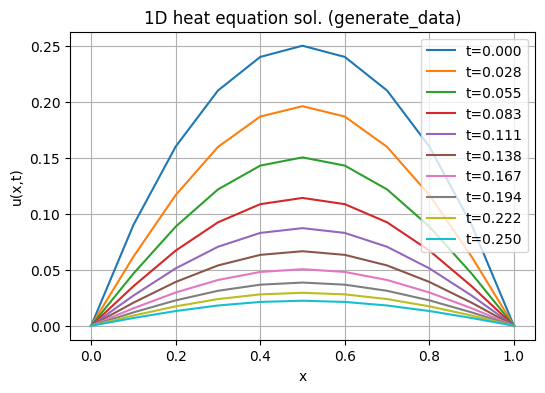

In [11]:
x = sys.x
t = t_train
U = u[0]


n_plot = min(10, len(t))
indices = np.linspace(0, len(t) - 1, n_plot, dtype=int)

plt.figure(figsize=(6, 4))
for i in indices:
    plt.plot(x, U[i], label=f"t={t[i]:.3f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D heat equation sol. (generate_data)")
plt.legend()
plt.grid(True)
plt.show()


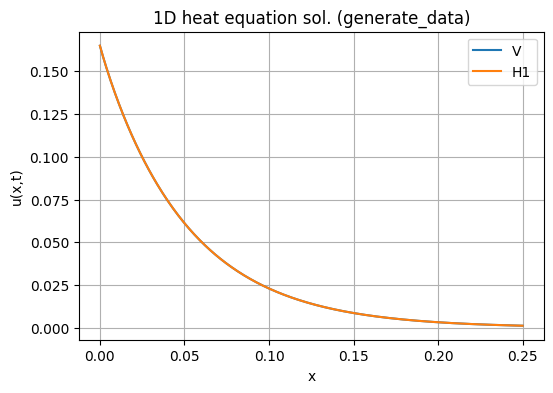

In [12]:
V_d = []
u_copy = u.copy()
dx = sys.dx
A = sys.A
H1 = [0.5 * u.T @ (-A) @ u * dx for u in U]
H2 = [0.5 * np.sum(u[0:-1]**2) * dx   for u in U]
for u_d in u_copy[0]:
    Vi =sys.V(np.array([u_d]))*(-sys.dx)
    V_d.append(Vi[0])

V_d =np.array(V_d)
plt.figure(figsize=(6, 4))
plt.plot(t, V_d, label=f"V")
plt.plot(t, H1, label=f"H1")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D heat equation sol. (generate_data)")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
L=1.0
N=10
T=0.25
dt=0.025

sys = HeatEquation(N = N, L=L, dt=dt, T=T)

integrator = "midpoint"
ntraj_train = 50
t_train = np.linspace(0, T, int(1/dt))

#BDF = True betyr du bruker BDF integrator i sample_trajectory, BDF = False betyr du bruker AVF integrator, hvor sistnevnte er omtrent 2x raskere for heat equation
(u_start, u_end, t_start, dt, xspatial), dudt_tensor, u, u0_  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, BDF = False)

100%|██████████| 50/50 [00:06<00:00,  7.23it/s]


In [14]:
class ForwardPadding(nn.Module):
    """
    Module that performs periodic forward padding on the last dimension of the input tensor.
    The tensor is padded by adding the first d elements to the end of the tensor.

    Parameters
    ----------
    d : int
        The number of elements to pad at the end of the tensor.
    """
    def __init__(self, d):
        super().__init__()
        self.d = d

    def forward(self, u):
        return torch.cat([u, u[..., : self.d]], dim=-1)


class Summation(nn.Module):
    """
    Module that performs summation along all dimensions except the batch dimension.
    It computes the sum of elements across each dimension and keeps the dimensionality
    intact by using the keepdims=True argument.
    """
    def __init__(self):
        super().__init__()

    def forward(self, u):
        axis = tuple(range(1, np.ndim(u)))
        return u.sum(axis=axis, keepdims=True)
    

class CentralPadding(nn.Module):
    """
    Module that performs periodic even padding on the last dimension of the input tensor.
    The tensor is padded by adding the first d elements to the end and the last d elements before
    the beginning of the tensor.

    Parameters
    ----------
    d : int
        The number of elements to pad on each side of the tensor.
    """
    def __init__(self, d):
        super().__init__()
        self.d = d

    def forward(self, x):
        return torch.cat([x[..., -self.d :], x, x[..., : self.d]], dim=-1)

In [15]:
class BaseNN(torch.nn.Module):
    def __init__(self,nstates,noutputs=1, hidden_dim=50):
        #State dependent
        super().__init__()

        self.nstates = nstates
        self.noutputs = noutputs
        self.hidden_dim = hidden_dim
      

        input_dim = 1
        pad = ForwardPadding(d=1)
        conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=2)
        conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1, bias=None)
        summation = Summation()

        self.model = nn.Sequential(
            pad,
            conv1,
            nn.Tanh(),
            conv2,
            nn.Tanh(),
            conv3,
            summation,
        )

    def forward(self, x=None, t=None, xspatial=None):
 
        #spatial_basis = torch.cat([torch.sin(2 * torch.pi / self.period * xspatial),
                       #      torch.cos(2 * torch.pi / self.period * xspatial),],axis=-2,)
        return self.model(x)

In [16]:
class PDEpHNN(BaseNN):
    def __init__(self,nstates, hidden_dim=100,period=20, number_of_intermediate_outputs=4, input_dim = 1):
        noutputs = 1
        super().__init__(nstates,noutputs,hidden_dim)
        self.period = period
        self.number_of_intermediate_outputs = number_of_intermediate_outputs
        
        
        pad = CentralPadding(d=2)
        hidden_dim_pre = 20
        dnn_pre = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim_pre, kernel_size=1),
            nn.Tanh(),
            nn.Conv1d(hidden_dim_pre, hidden_dim_pre, kernel_size=1),
            nn.Tanh(),
            nn.Conv1d(hidden_dim_pre, hidden_dim_pre, kernel_size=1),
            nn.Tanh(),
            nn.Conv1d(hidden_dim_pre, hidden_dim_pre, kernel_size=1),
            nn.Tanh(),
            nn.Conv1d(
                hidden_dim_pre,
                number_of_intermediate_outputs * input_dim,
                kernel_size=1,
            ),
        )

        conv1 = nn.Conv1d(
            number_of_intermediate_outputs * input_dim, hidden_dim, kernel_size=5
        )
        conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        conv3 = nn.Conv1d(hidden_dim, noutputs, kernel_size=1, bias=None)

        self.model = nn.Sequential(
            pad,
            dnn_pre,
            conv1,
            nn.Tanh(),
            conv2,
            nn.Tanh(),
            conv3,
        )



In [17]:
class PDEIntegralNN(PDEpHNN):
    """
    Neural network for estimating the quadrature approximation of an integral over the spatial
    discretization points where the states of a PDE is evaluated.
    It is based on the PDEBaseNN architecture and takes state variables as input and outputs a
    scalar function.

    Parameters
----------
    nstates : int
        Number of states in the input.
    hidden_dim : int, optional
    Dimension of hidden layers. Default is 100.

    """
    def __init__(self, nstates, hidden_dim=100):
        super().__init__(nstates, 1, hidden_dim)

In [18]:

class A_estimator(torch.nn.Module):
    """
    Creates an estimator of a symmetric convolution operator to apply to
    the left-hand side of the PDE system or the integral V.

    Parameters
    ----------
    kernel_size : int
    ttype : torch type, default torch.float32

    """

    def __init__(self, kernel_size=3, ttype=torch.float32):
        super().__init__()

        self.ttype = ttype
        self.kernel_size = kernel_size
        d = int((kernel_size - 1) / 2)
        self.ls = torch.nn.Parameter(
            torch.zeros(d, dtype=self.ttype), requires_grad=True
        )

    def forward(self, x=None):
        """
        Returns
        -------
        (N, N) tensor
            Damping matrix
        """
        if self.kernel_size == 0:
            return torch.tensor([0], dtype=self.ttype).reshape(1, 1, 1)
        else:
            return torch.concat(
                [self.ls, torch.tensor([1], dtype=self.ttype), self.ls]
            ).reshape(1, 1, self.kernel_size)


class S_estimator(torch.nn.Module):
    """
    Creates an estimator of a skew-symmetric convolution operator to apply to
    the integral H.

    Parameters
    ----------
    kernel_size : int
    ttype : torch type, default torch.float32

    """

    def __init__(self, kernel_size=3, ttype=torch.float32):
        super().__init__()

        self.ttype = ttype
        self.kernel_size = kernel_size
        if self.kernel_size > 1:
            d = int((kernel_size - 3) / 2)
            self.ls = torch.nn.Parameter(
                torch.zeros(d, dtype=self.ttype), requires_grad=True
            )

    def forward(self, x=None):
        """
        Returns
        -------
        (N, N) tensor
            Damping matrix
        """
        if self.kernel_size == 1 or self.kernel_size == 0:
            return torch.tensor([0], dtype=self.ttype).reshape(1, 1, 1)
        else:
            return torch.concat(
                [-self.ls, torch.tensor([-1.0, 0.0, 1.0], dtype=self.ttype), self.ls]
            ).reshape(1, 1, self.kernel_size)

In [61]:
class PDE_PHNN(torch.nn.Module):
    def __init__(self,nstates,kernel_sizes=[1, 3, 1, 0], init_sampler=None, V=None, H=None, f=None, R=None, S=None, A=None):
        super().__init__()
        self.kernel_sizes = kernel_sizes
        self.nstates = nstates
        self.d_type = torch.float32

        
        if init_sampler is not None:
            self._initial_condition_sampler = init_sampler
      
        if V is not None:
            self.V = V
        else:
            self.V = PDEIntegralNN(nstates=self.nstates)
        if H is not None:
            self.H = H
        else:
            self.H = PDEIntegralNN(nstates=self.nstates)

        if S is not None:
            self.S = S
            self.is_trainable_S = False
        else:
            self.S = S_estimator(kernel_size=self.kernel_sizes[1])
            self.is_trainable_S = True
        if R is not None:
            self.R = R
            self.is_trainable_R = False
        else:
            self.R = A_estimator(kernel_size=self.kernel_sizes[2])
            self.is_trainable_R = True
        if A is not None:
            self.A = A
            self.is_trainable_A = False
        else:
            self.A = A_estimator(kernel_size=self.kernel_sizes[0])
            self.is_trainable_A = True


        
    def dV(self, u):
        u = u.detach().requires_grad_()
        return torch.autograd.grad(self.V(u).sum(),u,retain_graph=self.training,create_graph=self.training)[0]
    

    def dH(self, u):
        u = u.detach().requires_grad_()
        return torch.autograd.grad(self.H(u).sum(),u,retain_graph=self.training,create_graph=self.training)[0]
    
    def u_dot(self, u, t, xspatial=None):

        rhs = torch.zeros_like(u)

        if self.kernel_sizes[1] != 0:
            if self.is_trainable_S:
                S = self.S()
            else:
                S = self.S
            if self.H is None:
                dH = torch.zeros_like(u)
            else:
                dH = self.dH(u)
    
            d = int((self.kernel_sizes[1]-1) / 2)
            dH_padded = torch.cat([dH[..., self.nstates -d:], dH, dH[..., :d]], dim=-1)
       
            rhs += torch.nn.functional.conv1d(dH_padded, S)

        if self.kernel_sizes[2] != 0:
            if self.is_trainable_R:
                R = self.R()
            else:
                R = self.R
            if self.V is None:
                dV = torch.zeros_like(u)
            else:
                dV = self.dV(u)
            d = int((self.kernel_sizes[2]-1) / 2)
            dV_padded = torch.cat([dV[..., self.nstates -d:], dV, dV[..., :d]], dim=-1)
          
            rhs += -torch.nn.functional.conv1d(dV_padded, R)

        if self.kernel_sizes[3] != 0:
            if self.f is not None:
                rhs += self.kernel_sizes[3] * self.f(u, t, xspatial)

        return rhs
    
    def lhs(self,dudt):
        if self.kernel_sizes[0] == 1:
            return dudt
        else:
            if self.is_trainable_A:
                A = self.A()
            else:
                A = self.A
            d = int((self.kernel_sizes[0] - 1) / 2)
            dudt_pad = torch.cat([dudt[..., self.nstates - d :], dudt, dudt[..., :d]], dim=-1)
            A_dudt = torch.nn.functional.conv1d(dudt_pad, A)
            return A_dudt
        
     
        
    def time_derivative_step(self, integrator, u_start, dt,t_start, u_end=None, xspatial=None):
        #integrator, u_start, u_end, t_start, t_end, dt, xspatial=None)
        if integrator == "RK4":
            return RK4_time_derivative(self.u_dot ,u_start, dt, t_start, xspatial)
        elif integrator == "midpoint":
            return symplectic_midpoint_time_derivative(self.u_dot, u_start, dt, t_start, xspatial, u_end)
                                                      
     
  
       

    def simulate_trajectory(self,t_sample, xspatial= None, u0=None, integrator=None):
        if u0 is None:
            u0 = self._initial_condition_sampler()

        if xspatial is None:
            xspatial_tensor = None
        else:
            xspatial_tensor =  torch.tensor(np.array(xspatial).reshape(1, xspatial.shape[-1]), dtype=self.d_type)

        t_sample =  torch.tensor(t_sample, dtype=self.d_type)
        
        M = u0.shape[0]
        nT = t_sample.shape[0]  

        u0 = u0.reshape(1, u0.shape[-1])
        U = torch.zeros([nT, u0.shape[-1]])
        U[0, :] = u0

        
        if self.kernel_sizes[0] == 1:
            for i, t_step in enumerate(t_sample[:-1]):
                t_step = torch.squeeze(t_step).reshape(-1, 1)
                dt = t_sample[i + 1] - t_step
                U[i + 1, :] = U[i, :] + dt * self.time_derivative_step(integrator = integrator, u_start = U[i : i + 1, :], u_end= U[i : i + 1, :], t_start = t_step, dt = dt, xspatial=xspatial_tensor)
    

        else:
            d = int((self.kernel_sizes[0] - 1) / 2)
            A = self.A().detach().numpy()
            diagonals = np.concatenate([A[0, :, (d + 1) :], A[0], A[0, :, : -(d + 1)]],axis=1).T.repeat(M, axis=1)
            offsets = np.concatenate([np.arange(-M + 1, -M + 1 + d),np.arange(-d, d + 1),np.arange(M - d, M)])
            D = diags(diagonals, offsets, (M, M)).toarray()
        
            for i, t_step in enumerate(t_sample[:-1]):
                t_step = torch.squeeze(t_step).reshape(-1, 1)
                dt = t_sample[i + 1] - t_step
                U[i + 1, :] = U[i, :]+ dt* np.linalg.solve(D,self.time_derivative_step(integrator = integrator, u_start = U[i : i + 1, :], u_end= U[i : i + 1, :], t_start = t_step, dt = dt, xspatial=xspatial_tensor).detach().T).T
                
        return U.detach().numpy()


In [35]:
L=1.0
N=10
T=0.25
dt=0.0025

sys = HeatEquation(N = N, L=L, dt=dt, T=T)
init_sampler = lambda rng=None: sys._initial_condition_sampler(rng)

integrator = "midpoint"
ntraj_train = 30
t_train = np.linspace(0, T, int(1/dt))

ntraj_val = 10
t_val = np.linspace(0, T, int(1/dt))

#BDF = True betyr du bruker BDF integrator i sample_trajectory, BDF = False betyr du bruker AVF integrator, hvor sistnevnte er omtrent 2x raskere for heat equation
(u_start, u_end, t_start, dt, xspatial), dudt_tensor, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, BDF = False)
train_data = (u_start, u_end,t_start, dt, xspatial), dudt_tensor

(u_start, u_end, t_start, dt, xspatial), dudt_tensor, u_val, u0s_val  =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator, BDF = False)
val_data = (u_start, u_end,t_start, dt, xspatial), dudt_tensor


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


In [52]:
A = torch.tensor(np.array([[[1]]]),dtype=torch.float32)
S = torch.tensor(np.array([[[0, 0, 0]]]),dtype=torch.float32)
R = torch.tensor(np.array([[[1]]]),dtype=torch.float32)

100%|██████████| 10/10 [01:30<00:00,  9.00s/it, epoch=9, loss=0.00607]


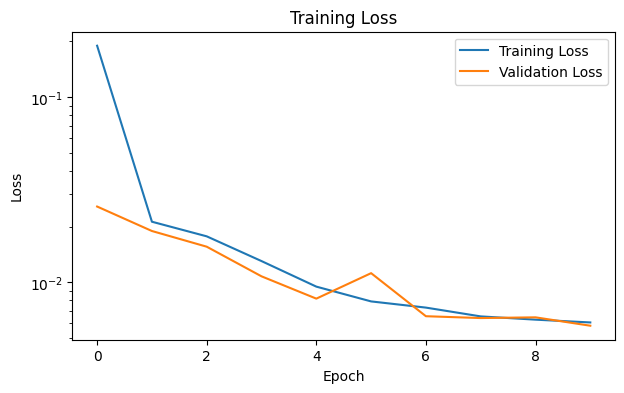

In [62]:
lr = 1e-3
epochs = 10
batch_size = 64
loss_func = torch.nn.MSELoss()

model = PDE_PHNN(nstates = sys.nstates, kernel_sizes=[1, 3, 1, 0], A = A, S = S)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

trainer = Training(model = model,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer, system = sys, batch_size=batch_size,epochs = epochs)
model, trainingdetails = trainer.train(loss_func=loss_func)

In [ ]:
L=1.0
N=10
T=0.5
dt=0.005

sys = HeatEquation(N = N, L=L, dt=dt, T=T)
init_sampler = lambda rng=None: sys._initial_condition_sampler(rng)

integrator = "midpoint"
ntraj_test = 1
t_test = np.linspace(0, T, int(1/dt))



(u_start, u_end, t_start, dt, xspatial), dudt_tensor, u_test, u0s_test  =  generate_data(system=sys,ntrajectories =ntraj_test, t_sample = t_test,integrator=integrator, BDF = False)
test_data = (u_start, u_end,t_start, dt, xspatial), dudt_tensor

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


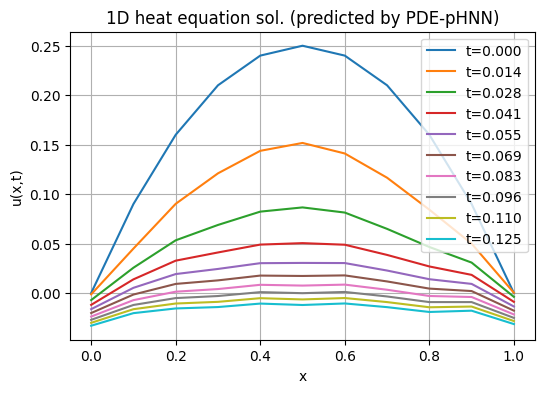

In [72]:
x = sys.x
t_test
u0s_test
U = model.simulate_trajectory(t_sample=t_test, u0=torch.tensor(u0s_test[0],dtype=torch.float32), integrator=integrator)


Nt_U, Nx = U.shape
Nt_t = len(t)


n_plot = min(10, Nt_U, Nt_t)
indices = np.linspace(0, min(Nt_U, Nt_t) - 1, n_plot, dtype=int)


x_plot = x if len(x) == Nx else (
    x[:Nx] if len(x) > Nx else np.linspace(x[0], x[-1], Nx)
)



plt.figure(figsize=(6, 4))
for i in indices:
    plt.plot(x_plot, U[i], label=f"t={t[i]:.3f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D heat equation sol. (predicted by PDE-pHNN)")
plt.legend()
plt.grid(True)
plt.show()


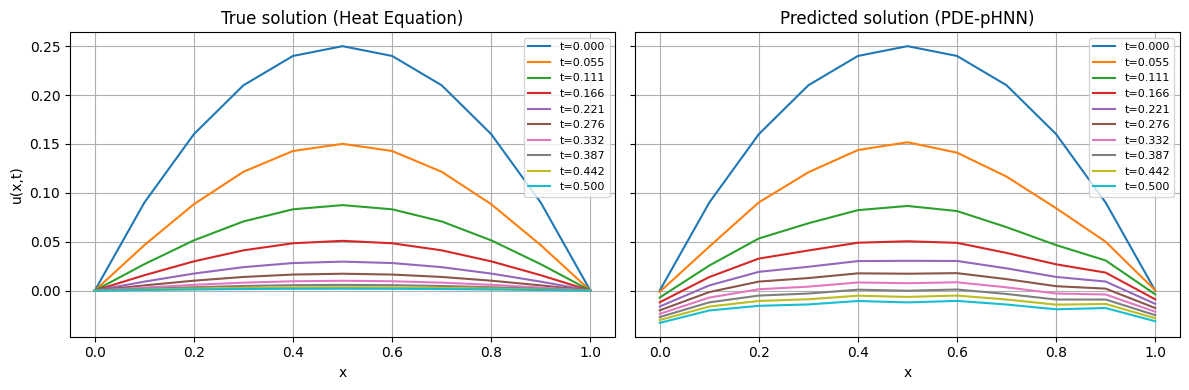

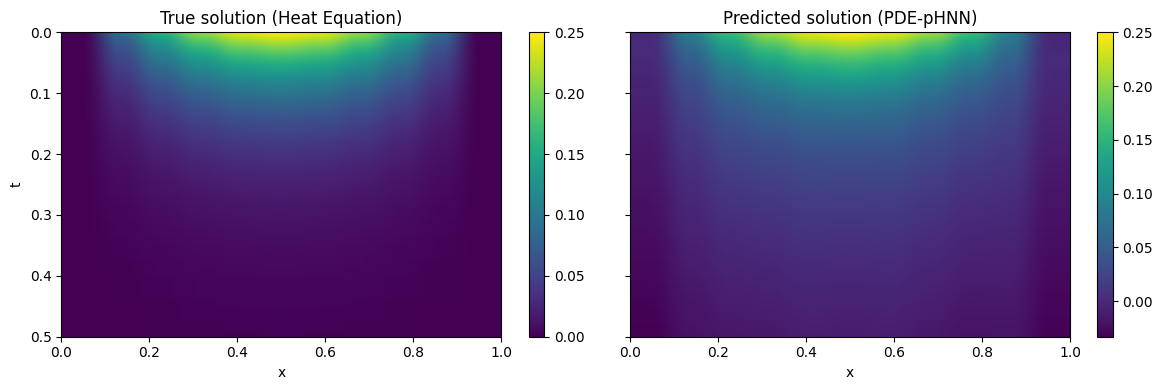

In [74]:

x = sys.x
t = t_test
U_pred = U               
U_true = u_test[0]       

Nt_pred, Nx_pred = U_pred.shape
Nt_true, Nx_true = U_true.shape
Nt = min(Nt_pred, Nt_true, len(t))
Nx = min(Nx_pred, Nx_true, len(x))

U_pred = U_pred[:Nt, :Nx]
U_true = U_true[:Nt, :Nx]
x_plot = x[:Nx]
t_plot = t[:Nt]


n_plot = min(10, Nt)
indices = np.linspace(0, Nt - 1, n_plot, dtype=int)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)


for i in indices:
    axes[0].plot(x_plot, U_true[i], label=f"t={t_plot[i]:.3f}")
axes[0].set_title("True solution (Heat Equation)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("u(x,t)")
axes[0].grid(True)
axes[0].legend(fontsize=8)


for i in indices:
    axes[1].plot(x_plot, U_pred[i], label=f"t={t_plot[i]:.3f}")
axes[1].set_title("Predicted solution (PDE-pHNN)")
axes[1].set_xlabel("x")
axes[1].grid(True)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
im0 = axes[0].imshow(U_true, extent=[x_plot[0], x_plot[-1], t_plot[-1], t_plot[0]],
                     aspect='auto', cmap='viridis')
axes[0].set_title("True solution (Heat Equation)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(U_pred, extent=[x_plot[0], x_plot[-1], t_plot[-1], t_plot[0]],
                     aspect='auto', cmap='viridis')
axes[1].set_title("Predicted solution (PDE-pHNN)")
axes[1].set_xlabel("x")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()
